# WEIGHTED MAX-CUT PROBLEM WITH QISKIT

Given an arbitary weighted undirected graph, implement the circuit that solves the corresponding Max-Cut problem on gate-based quantum machines.

In [1]:
!git clone https://github.com/LINKS-Foundation-CPE/Master-QCC-2022-2023.git

Cloning into 'Master-QCC-2022-2023'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 159 (delta 70), reused 127 (delta 47), pack-reused 0
Receiving objects: 100% (159/159), 593.36 KiB | 3.93 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
%cd /content/Master-QCC-2022-2023/

/content/Master-QCC-2022-2023


In [3]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 5.6 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.42.1-py3-no

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import random
random.seed(42)
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

from src.qiskit_qaoa.utils import *

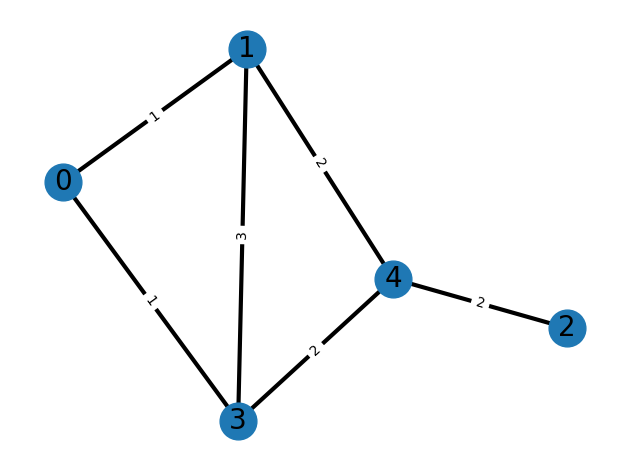

In [5]:
n = 5
graph = nx.gnp_random_graph(n, p=0.5, seed=3)
for (u,v,w) in graph.edges(data=True):
    w['weight'] = random.randint(1,5)
pos = nx.spring_layout(graph, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(graph, pos, node_size=700)
# edges
nx.draw_networkx_edges(graph, pos, width=3)
# node labels
nx.draw_networkx_labels(graph, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

ax = plt.gca()
plt.axis("off")
plt.tight_layout()
plt.show()

adjacency = nx.adjacency_matrix(graph).todense()

In [6]:
# mixing Hamiltonian
beta = Parameter("beta")
qc_mix = QuantumCircuit(n)
for i in range(n):
    qc_mix.rx(beta, i)

In [7]:
# problem Hamiltonian
gamma = Parameter("gamma")
qc_p = QuantumCircuit(n)
for pair in list(graph.edges()):  # pairs of nodes
    qc_p.rzz(gamma, pair[0], pair[1])

In [8]:
# state initialization
qc_0 = QuantumCircuit(n)
for i in range(n):
    qc_0.h(i)

In [9]:
qc_qaoa = QuantumCircuit(n)
qc_qaoa.append(qc_0, range(n))
qc_qaoa.append(qc_p, range(n))
qc_qaoa.append(qc_mix, range(n))
qc_qaoa.decompose().decompose().draw()

┌─────────┐                                              ┌───────────┐»
q_0: ┤ U2(0,π) ├──■─────────────────■────■─────────────────■──┤ R(beta,0) ├»
     ├─────────┤┌─┴─┐┌───────────┐┌─┴─┐  │                 │  └───────────┘»
q_1: ┤ U2(0,π) ├┤ X ├┤ Rz(gamma) ├┤ X ├──┼─────────────────┼────────■──────»
     ├─────────┤└───┘└───────────┘└───┘  │                 │        │      »
q_2: ┤ U2(0,π) ├─────────────────────────┼─────────────────┼────────┼──────»
     ├─────────┤                       ┌─┴─┐┌───────────┐┌─┴─┐    ┌─┴─┐    »
q_3: ┤ U2(0,π) ├───────────────────────┤ X ├┤ Rz(gamma) ├┤ X ├────┤ X ├────»
     ├─────────┤                       └───┘└───────────┘└───┘    └───┘    »
q_4: ┤ U2(0,π) ├───────────────────────────────────────────────────────────»
     └─────────┘                                                           »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                              ┌───────────┐                  »
«q_1: ───────────────■────■─────────────────■──┤ R(beta,0) ├──────────────────»
«                    │    │                 │  └───────────┘                  »
«q_2: ───────────────┼────┼─────────────────┼────────■─────────────────────■──»
«     ┌───────────┐┌─┴─┐  │                 │        │                     │  »
«q_3: ┤ Rz(gamma) ├┤ X ├──┼─────────────────┼────────┼─────────────────────┼──»
«     └───────────┘└───┘┌─┴─┐┌───────────┐┌─┴─┐    ┌─┴─┐    ┌───────────┐┌─┴─┐»
«q_4: ──────────────────┤ X ├┤ Rz(gamma) ├┤ X ├────┤ X ├────┤ Rz(gamma) ├┤ X ├»
«                       └───┘└───────────┘└───┘    └───┘    └───────────┘└───┘»
«                                                 
«q_0: ────────────────────────────────────────────
«                                                 
«q_1: ────────────────────────────────────────────
«     ┌───────────┐                               
«q_2: ┤ R(beta,0) ├───────────────────────────────
«     └───────────┘                  ┌───────────┐
«q_3: ──────■─────────────────────■──┤ R(beta,0) ├
«         ┌─┴─┐    ┌───────────┐┌─┴─┐├───────────┤
«q_4: ────┤ X ├────┤ Rz(gamma) ├┤ X ├┤ R(beta,0) ├
«         └───┘    └───────────┘└───┘└───────────┘

In [10]:
expectation = get_expectation(graph)
res = minimize(expectation,
               x0=[0,0],
               method='Powell')
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6.810546875
       x: [ 2.517e+00  6.087e-01]
     nit: 4
   direc: [[ 0.000e+00  1.000e+00]
           [-1.735e-02 -6.275e-03]]
    nfev: 226

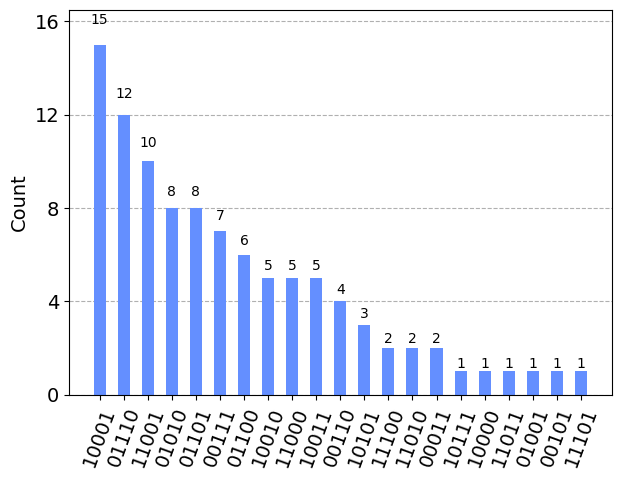

In [11]:
backend = Aer.get_backend('aer_simulator')
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10, shots=100).result().get_counts()
plot_histogram(counts, sort='value_desc')

In [12]:
for sol in sorted(counts, key=counts.get, reverse=True):
    vertexes = [idx for idx, item in enumerate(sol) if '1' in item]
    print(f'Vertexes: {vertexes} --- Cut: { -maxcut_obj(sol, graph)}')

Vertexes: [0, 4] --- Cut: 8
Vertexes: [1, 2, 3] --- Cut: 8
Vertexes: [0, 1, 4] --- Cut: 8
Vertexes: [1, 2, 4] --- Cut: 6
Vertexes: [1, 3] --- Cut: 6
Vertexes: [2, 3, 4] --- Cut: 6
Vertexes: [1, 2] --- Cut: 8
Vertexes: [0, 3, 4] --- Cut: 8
Vertexes: [0, 1] --- Cut: 6
Vertexes: [0, 3] --- Cut: 6
Vertexes: [2, 3] --- Cut: 8
Vertexes: [0, 2, 4] --- Cut: 6
Vertexes: [3, 4] --- Cut: 8
Vertexes: [0, 1, 3] --- Cut: 4
Vertexes: [0, 1, 2] --- Cut: 8
Vertexes: [0, 1, 2, 4] --- Cut: 6
Vertexes: [2, 4] --- Cut: 4
Vertexes: [1, 4] --- Cut: 8
Vertexes: [0, 1, 3, 4] --- Cut: 2
Vertexes: [0] --- Cut: 2
Vertexes: [0, 2, 3, 4] --- Cut: 6
